In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Class Activation Maps 


## Veri setinin indirilmesi ve Çıkartılması 
http://www.vision.caltech.edu/Image_Datasets/Caltech101/ linkinden indirdiğimiz datayı drive ortamına taşıyıp buradan !tar komutu ile drivede belirttiğimiz path'e çıkardık. Veri setinde 101 sınıfa ait resimler bulunuyor. Modeli bu resimler üzerinde deneyeceğiz. 

In [4]:
!tar -xvf "/content/drive/MyDrive/DATASETS/data_zip/101_ObjectCategories.tar.gz" -C "/content/drive/MyDrive/DATASETS/"

# Kullanılacak Kütüphanelerin İmport Edilmesi

In [3]:
# imagelerin pathlerini almak için 
import glob

# Resimleri göstermek ve düzenlemek ve scale etmek için
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import scipy

# Keras modellerini import etmek ve preprocess işlemleri için
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions

In [5]:
# constants
IMAGE_SHAPE = (224,224,3)
SAVE_PATH = "/content/drive/MyDrive/Projects/Class Activations/save_images/"
IMAGE_PATH = "/content/drive/MyDrive/DATASETS/101_ObjectCategories/*/*.jp*g"

# Imagelerin Pathlerinin Alınması
Driveda klasörler içerisinde bulunan imagelerin pathlerini almak için glob kütüphanesini kullanalım. glob ile dosya yolur ve data formatı vererek o pathteki ilgili formattaki tüm dataları alabiliriz. 

In [13]:
images_path = glob.glob(IMAGE_PATH)

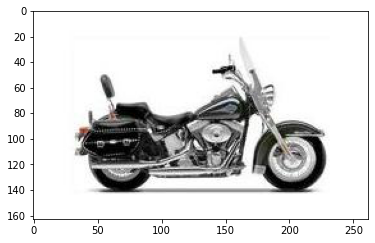

In [14]:
plt.imshow(image.load_img(np.random.choice(images_path)))
plt.show()

## Modeller 

### Resnet Modeli
Activation mapping ve prediction için resnet modeli kullacağız. Resnet modeli milyonlarca veri ile eğitilmiş ve özellik çıkarmada oldukça başarılı bir model.   

### Feature Map Modeli 
Bu model için resnet modelinin global average pooling layerından bir önceki layer olan "conv5_block3_out" (son aktivasyon) layerını get_layer ile alıyoruz.  
Keras Functional API ile yeni bir model oluşturalım. Feature maps çıkarmak için bu modeli kullanacağız.  



In [15]:
resnet = ResNet50(input_shape=IMAGE_SHAPE)
# resnet.summary()

activation_layer = resnet.get_layer("conv5_block3_out")
model = Model(inputs = resnet.input,outputs=activation_layer.output)
# model.summary()

Son katmanın weightlerini de ayrı bir değişkende tutuyoruz. Modelin predict ettiği sınıfa ait weightleri ve çıkartılan özellikleri dot product çarparak modelin yaptığı tahminde imagein hangi kısmında ki özellikler etkili olduğunu öğrenebiliriz.  

In [16]:
last_layer = resnet.get_layer("predictions")
last_layer_weights = last_layer.get_weights()[0]

## Activation Maps Oluşturulması ve Gösterilmesi 
Random olarak bir image seçelim. Bu seçtiğimiz image'i resnet modeline göndermek için belli processlerden geçirelim.Özellik çıkarımda kullanacağımız model gönderip predict ettirim. (7x7x2048) boyutunda bir çıktı alıyoruz. Bu bizim feature map verimiz.  

Resnet modeline imagei gönderip classification yapmasını sağlıyoruz. Hangi sınıfı predict ettiğini np.argmax ile öğreniyoruz.  
 Bir değişkende tuttuğumuz weight içerisinden ilgili sınıfa giden weightleri çekiyoruz. Bu weightler ve feature map dot product ile hesaplayıp. 7x7 bir matrix elde ediyoruz.  
Bu elde ettiğimiz matriksi upsampling ile büyüterek plot ediyoruz. 

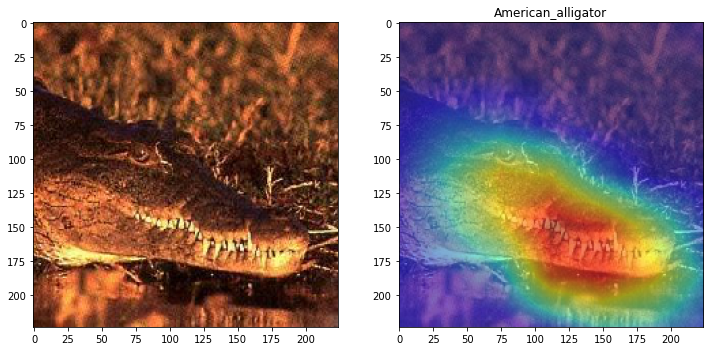

In [29]:
img = image.load_img(np.random.choice(images_path),target_size=(IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
x = preprocess_input(np.expand_dims(img,0))
feature_maps = model.predict(x)[0]

probs = resnet.predict(x)
class_name = decode_predictions(probs)[0][1][1] # [('n04517823', 'vacuum', 0.23624058),('n04367480', 'swab', 0.18600261),]
pred = np.argmax(probs[0])

w = last_layer_weights[:,pred]

cam = feature_maps.dot(w)
cam_up = scipy.ndimage.zoom(cam,(32,32),order=1)

plt.figure(figsize=(12, 6)) 
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img,alpha=0.8)
plt.title(class_name)
plt.imshow(cam_up,alpha=0.5,cmap="jet")
plt.savefig(f"{SAVE_PATH}{class_name}.jpg")
plt.show()